In [441]:
import os
import cv2
from matplotlib import pyplot as plt
from unet_project.image_utils import ImageUtils
from unet_project.data_augmentation import DataAugmentation
from unet_project.u_net import Unet
from unet_project.create_patches import PatchesCreator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm_notebook
import numpy as np
from imgaug import augmenters as iaa

In [442]:
path_to_imgs = '/home/ajuska/Dokumenty/Skola/diplomka/disk_data/train_imgs/train'
path_to_masks = '/home/ajuska/Dokumenty/Skola/diplomka/disk_data/train_masks/train'
img_height = 224
img_width = 224
img_channels = 3

In [443]:
def augmentation():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.1)), 
        iaa.GaussianBlur((0, 1.0)), 
        iaa.OneOf([
            iaa.Dropout((0.01, 0.1), per_channel=0.5), 
            iaa.CoarseDropout((0.05, 0.1), size_percent=(0.05, 0.08), per_channel=0.1),
        ]),
        iaa.ContrastNormalization((0.9, 1.1)),
        iaa.Multiply((0.9, 1.1), per_channel=0.1),
        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-0.01, 0.01),
            shear=(-8, 8)
        )
    ], random_order=True) 
    return seq

seq = augmentation()

In [458]:
def data_gen(path_to_imgs, path_to_masks, batch_size):
    names = os.listdir(path_to_imgs)
    random.shuffle(names)
    while 1:
        img = []
        mask = []       
        
        for idx in range(int(batch_size/2)):
            train_img = cv2.imread(path_to_imgs+'/'+names[idx])/255
            train_img =  cv2.resize(train_img, (img_height, img_width))
            img.append(train_img)
            
            train_mask = cv2.imread(path_to_masks+'/'+names[idx], cv2.IMREAD_GRAYSCALE)/255
            train_mask = cv2.resize(train_mask, (img_height, img_width))
            train_mask = train_mask.reshape(img_height, img_width, 1)
            mask.append(train_mask)
        
        seq = augmentation()
        seq_det = seq.to_deterministic()
        images_aug = seq_det.augment_images(np.array(img).astype(np.uint8))    
        mask_aug = seq_det.augment_images(np.array(mask).astype(np.uint8))
        
        idx_aug = 0
        for idx in range(int(batch_size/2), batch_size):
            img.append(images_aug[idx_aug])
            mask.append(mask_aug[idx_aug])
            idx_aug = idx_aug + 1
            
        yield np.array(img), np.array(mask)
        
train_frame_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk_data/train_imgs/train'
train_mask_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk_data/train_masks/train'

val_frame_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk_data/val_imgs/val'
val_mask_path = '/home/ajuska/Dokumenty/Skola/diplomka/disk_data/val_masks/val'

# Train the model
train_gen = data_gen(train_frame_path, train_mask_path, batch_size=4)
val_gen = data_gen(val_frame_path, val_mask_path, batch_size=4)

In [459]:
img[0].shape

(1000, 3)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import random

NO_OF_TRAINING_IMAGES = len(os.listdir('/home/ajuska/Dokumenty/Skola/diplomka/disk_data/train_imgs/train'))
NO_OF_VAL_IMAGES = len(os.listdir('/home/ajuska/Dokumenty/Skola/diplomka/disk_data/val_imgs/val/'))

NO_OF_EPOCHS = 50

BATCH_SIZE = 16

unet = Unet(img_height=img_height, img_width=img_width, img_channels=img_channels)
model = unet.create_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_unet_vessels.h5', verbose=1, save_best_only=True)

callbacks_list = [checkpointer, earlystopper]

results = model.fit_generator(train_gen, epochs=NO_OF_EPOCHS, 
                              steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                              validation_data=val_gen, 
                              validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                              callbacks=callbacks_list,
                              verbose=1)

Creating model.
Epoch 1/50
7/7 [==============================] - 21s 3s/step - loss: -10.7882 - acc: 0.3599 - val_loss: -34.6179 - val_acc: 0.4552

Epoch 00001: val_loss improved from inf to -34.61789, saving model to model_unet_vessels.h5
Epoch 2/50
7/7 [==============================] - 16s 2s/step - loss: -23.1233 - acc: 0.4986 - val_loss: -24.0472 - val_acc: 0.5462

Epoch 00002: val_loss did not improve from -34.61789
Epoch 3/50
1/7 [===>..........................] - ETA: 13s - loss: -23.7959 - acc: 0.6876

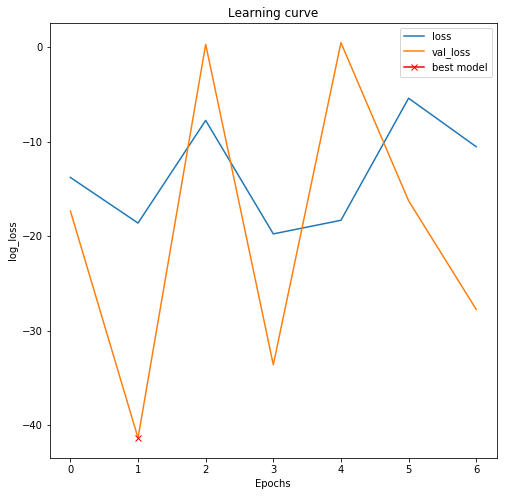

In [447]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [429]:
test_img = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk_data/val_imgs/val/Study_02_00099_02_R_registered.avi_average_image.tif')/255
test_img =  cv2.resize(test_img, (224, 224))

test_mask = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk_data/val_masks/val/Study_02_00099_02_R_registered.avi_average_image.tif', cv2.IMREAD_GRAYSCALE)/255
test_mask = cv2.resize(test_img, (224, 224))

In [430]:
test = np.expand_dims(test_img, axis=0)
preds = model.predict(test)

In [433]:
preds_t = (preds > 0.3)
prediction = np.squeeze(preds_t*1)

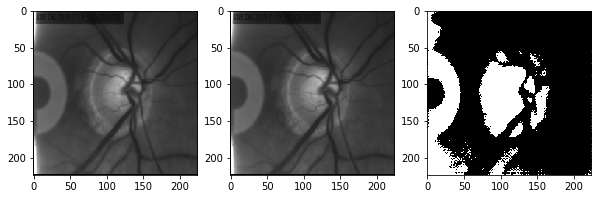

In [434]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test_img)
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')

In [435]:
from skimage import data, color
from skimage import measure
from scipy.signal import medfilt2d

In [436]:
test_img_filtered = medfilt2d(prediction.astype(np.uint8), 5)

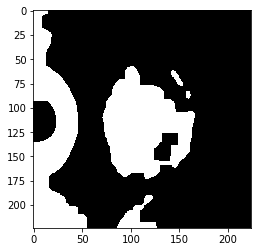

In [437]:
kernel = np.ones((12,12),np.uint8)
closing = cv2.morphologyEx(test_img_filtered, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

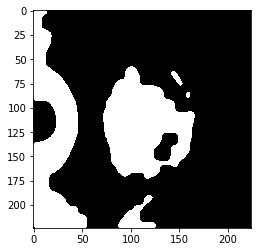

In [438]:
opening = medfilt2d(closing.astype(np.uint8), 5)
plt.imshow(opening, cmap='gray')

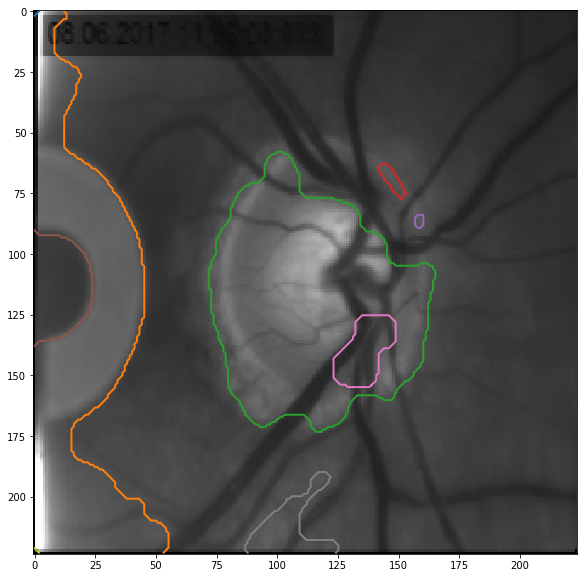

In [439]:
contours = measure.find_contours(opening, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test_img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)